In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew, kurtosis, norm, chi2
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
#dgs3mo = pd.read_csv('DGS3MO.csv')
dgs6mo = pd.read_csv('DGS6MO.csv')
dgs1 = pd.read_csv('DGS1.csv')
dgs2 = pd.read_csv('DGS2.csv')
dgs5 = pd.read_csv('DGS5.csv')
dgs7 = pd.read_csv('DGS7.csv')
dgs10 = pd.read_csv('DGS10.csv')
#dgs30 = pd.read_csv('DGS30.csv')

zero1 = pd.read_csv('THREEFY1.csv')
zero2 = pd.read_csv('THREEFY2.csv')
zero3 = pd.read_csv('THREEFY3.csv')
zero4 = pd.read_csv('THREEFY4.csv')
zero5 = pd.read_csv('THREEFY5.csv')
zero6 = pd.read_csv('THREEFY6.csv')
zero7 = pd.read_csv('THREEFY7.csv')
zero8 = pd.read_csv('THREEFY8.csv')
zero9 = pd.read_csv('THREEFY9.csv')
zero10 = pd.read_csv('THREEFY10.csv')

In [4]:
zero_list = []
for df in [zero1, zero2, zero3, zero4, zero5, zero6, zero7, zero8, zero9, zero10]:
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    df = df.set_index('observation_date')
    zero_list.append(df)

zero = pd.concat(zero_list, axis=1, join="inner").sort_index() / 100

In [5]:
dgs_list = []
for df in [dgs6mo, dgs1, dgs2, dgs5, dgs7, dgs10]:
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    df = df.set_index('observation_date')
    dgs_list.append(df)

dgs = pd.concat(dgs_list, axis=1, join="inner").sort_index() / 100

In [6]:
zero, dgs = zero.align(dgs, join = 'inner', axis=0)

In [7]:
def dy_distribution(df, start, end):
    for col in df.columns:
        data = df[col].diff().dropna()
        dy = data.loc[start:end]
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Histogram
        axes[0].hist(dy, bins=30, density=True)
        axes[0].set_title(f"Histogram of Δy: {col}")
        axes[0].set_xlabel("Δy")
        axes[0].set_ylabel("Density")

        # QQ plot
        stats.probplot(dy, dist="norm", plot=axes[1])
        axes[1].set_title(f"QQ Plot of Δy: {col}")

        plt.tight_layout()
        plt.show()
        print(f"{col}:")
        print(f"  Mean      = {dy.mean():.4f}")
        print(f"  Std       = {dy.std():.4f}")
        print(f"  Skewness  = {skew(dy):.2f}")
        print(f"  Kurtosis  = {kurtosis(dy, fisher=False):.2f}")

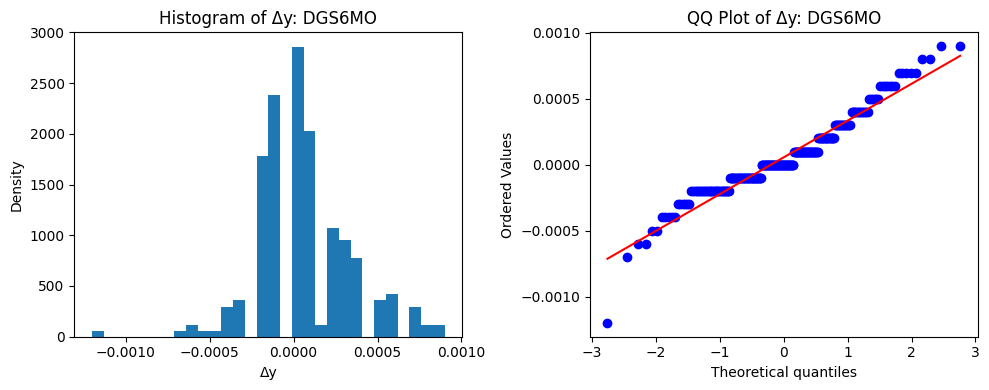

DGS6MO:
  Mean      = 0.0001
  Std       = 0.0003
  Skewness  = 0.19
  Kurtosis  = 4.76


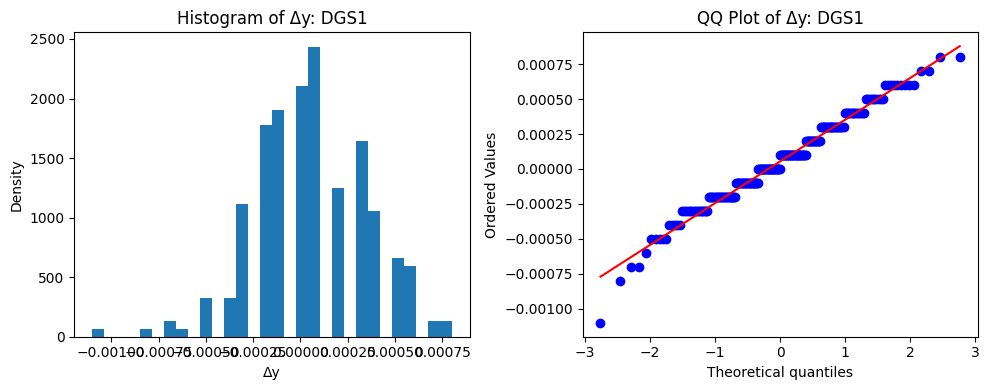

DGS1:
  Mean      = 0.0001
  Std       = 0.0003
  Skewness  = -0.17
  Kurtosis  = 3.52


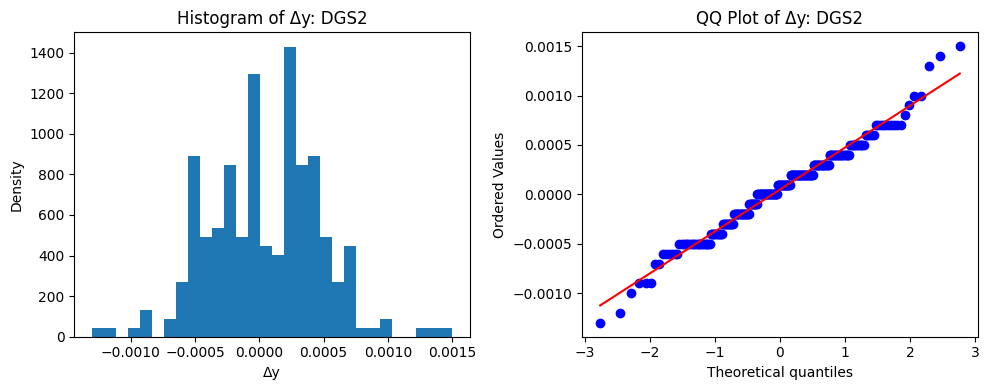

DGS2:
  Mean      = 0.0000
  Std       = 0.0004
  Skewness  = 0.03
  Kurtosis  = 3.77


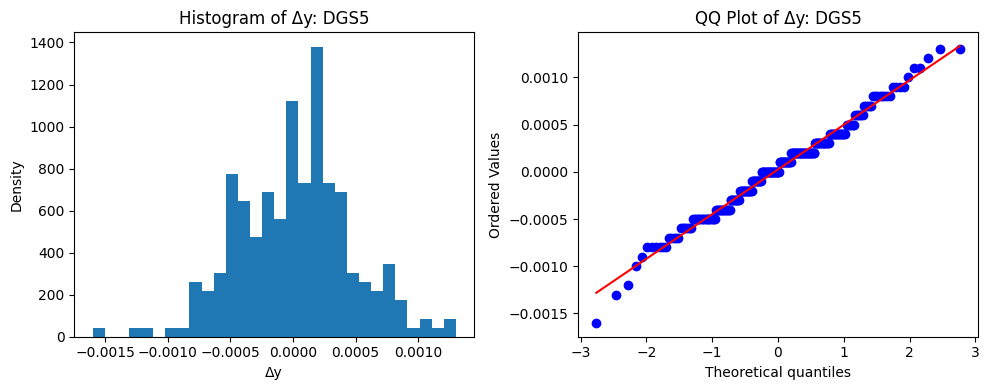

DGS5:
  Mean      = 0.0000
  Std       = 0.0005
  Skewness  = -0.05
  Kurtosis  = 3.37


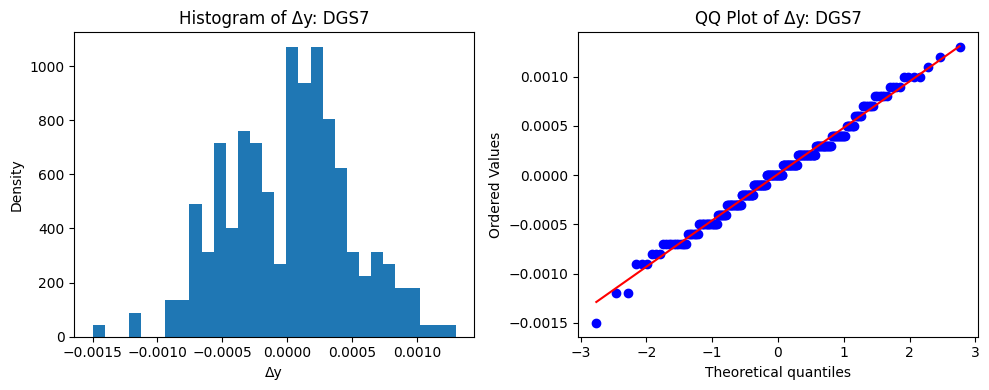

DGS7:
  Mean      = 0.0000
  Std       = 0.0005
  Skewness  = 0.02
  Kurtosis  = 3.13


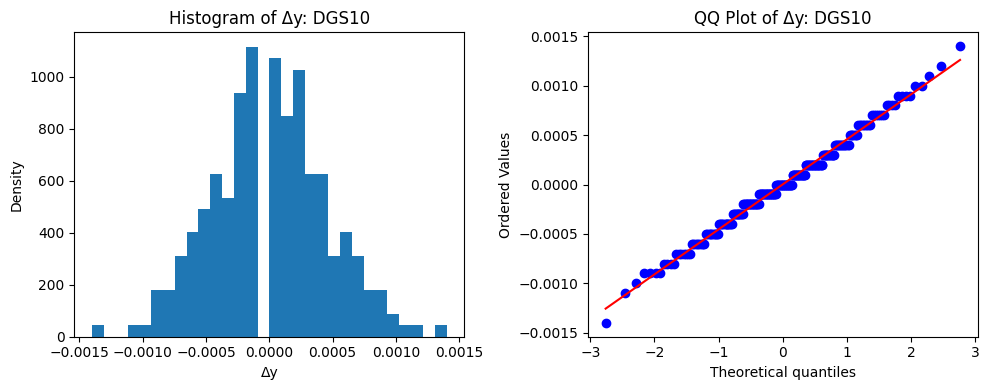

DGS10:
  Mean      = 0.0000
  Std       = 0.0005
  Skewness  = 0.09
  Kurtosis  = 3.17


In [8]:
dy_distribution(dgs, '2005-01-01', '2006-01-01')

In [9]:
def bond_cashflow_construction(maturity, coupon_rate, freq, notional = 100):
    term = maturity * freq
    coupon = notional * coupon_rate / freq
    cashflow = np.full(term, coupon)
    cashflow[-1] += notional
    
    return cashflow

def solve_x(tenors, par_yields, freq, dfs, i, power, powers):
    
    def F(x):
        df = np.r_[dfs, dfs[-1] * x ** powers]
        terms = int(round(tenors[i] * freq))
        coupon = np.full(terms, 100 * par_yields[i] / freq)
        return np.sum(df * coupon) + 100 * dfs[-1] * x ** power - 100
        
    return brentq(F, 1e-12, 1-1e-12)

# Assuming linear, par yields derived
def df_bootstrap(maturity, freq, tenors, par_yields):
    dfs = np.array([1 / (1 + par_yields[0]/freq)]) # t = 0.5 df
    for i in range(1, len(tenors)):
        power = int(round((tenors[i] - tenors[i-1]) * freq))
        powers = np.arange(1, power + 1, dtype=int)
        x = solve_x(tenors, par_yields, freq, dfs, i, power, powers)
        df = dfs[-1] * x ** powers
        dfs = np.concatenate([dfs, df])
    
    return dfs[:maturity * freq]

# Zero rates derived
def df_interpolate(maturity, freq, tenors, zero_rates):
    zt = tenors * zero_rates
    dt = 1/freq
    t = np.arange(0, maturity + 1e-12, dt)
    full_zt = np.interp(t, tenors, zt)
    dfs = np.exp(-full_zt)
    
    return dfs[1:maturity * freq + 1]
    
def PV(cashflow, dfs):
    return np.sum(cashflow * dfs)

In [10]:
def DV_par(maturity, freq, coupon_rate, tenors, par_yields, notional = 100, shock = 0.0001):
    cashflow = bond_cashflow_construction(maturity, coupon_rate, freq, notional)
    dfs = df_bootstrap(maturity, freq, tenors, par_yields)
    pv = PV(cashflow, dfs)
    
    dfs = df_bootstrap(maturity, freq, tenors, par_yields + shock)
    pv_shock = PV(cashflow, dfs)
    return pv_shock - pv
    
def DV_zero(maturity, freq, coupon_rate, tenors, zero_rates, notional = 100, shock = 0.0001):
    cashflow = bond_cashflow_construction(maturity, coupon_rate, freq, notional)
    dfs = df_interpolate(maturity, freq, tenors, zero_rates)
    pv = PV(cashflow, dfs)
    
    dt = 1/freq
    time = np.arange(dt, maturity + dt, dt)
    pv_shock = PV(cashflow, np.exp(-shock * time) * dfs)
    return pv_shock - pv

def KRDV(maturity, freq, coupon_rate, tenors, par_yields, notional = 100, shock = 0.0001):
    cashflow = bond_cashflow_construction(maturity, coupon_rate, freq, notional)
    dfs = df_bootstrap(maturity, freq, tenors, par_yields)
    pv = PV(cashflow, dfs)
    
    ts = []
    pv_shock = []
    for i, t in enumerate(tenors):
        ts.append(t)
        par_copy = par_yields.copy()
        par_copy[i] += shock
        dfs = df_bootstrap(maturity, freq, tenors, par_copy)
        pv_shock.append(PV(cashflow, dfs))
          
    krdvs = {t: krdv for t, krdv in zip(ts, np.array(pv_shock) - pv)}
    return krdvs

In [89]:
def unconditional_independence_test(exceptions):
    exceptions = np.asarray(exceptions).astype(int)
    N00 = N01 = N10 = N11 = 0
    for t in range(1, len(exceptions)):
        if exceptions[t-1] == 0 and exceptions[t] == 0:
            N00 += 1
        elif exceptions[t-1] == 0 and exceptions[t] == 1:
            N01 += 1
        elif exceptions[t-1] == 1 and exceptions[t] == 0:
            N10 += 1
        elif exceptions[t-1] == 1 and exceptions[t] == 1:
            N11 += 1
            
    pi = (N01 + N11) / (N00 + N01 + N10 + N11)
    pi0 = N01 / (N00 + N01) if (N00 + N01) > 0 else 0
    pi1 = N11 / (N10 + N11) if (N10 + N11) > 0 else 0   
    
    def safe_log(x):
        return np.log(x) if x > 0 else 0

    logL0 = (
        (N01 + N11) * safe_log(pi)
        + (N00 + N10) * safe_log(1 - pi)
    )

    logL1 = (
        N01 * safe_log(pi0)
        + N00 * safe_log(1 - pi0)
        + N11 * safe_log(pi1)
        + N10 * safe_log(1 - pi1)
    )

    LR_ind = 2 * (logL1 - logL0)
    p_value = 1 - chi2.cdf(LR_ind, df=1)

    return {
        'pi': pi,
        "p_value": p_value
    }
    
def VaR_backtest(dgs, window, maturity, freq, coupon_rate, par_tenors, notional = 100, shock = 0.0001, alpha = 0.99):
    dy = dgs.diff().dropna() * 10000
    z = norm.ppf(alpha)
    test_days = len(dy) - window
    cashflow = bond_cashflow_construction(maturity, coupon_rate, freq, notional = 100)
    VaRs = []
    SVaRs = []
    stressed = []
    short_vols = []
    cVaRs = []
    pcas = []
    explained_ratios = []
    #linear_PnLs = []
    actual_PnLs = []
    
    for i in range(test_days):
        current_date = dy.index[i + window - 1]
        next_date = dy.index[i + window]
        data = dy.iloc[i: i + window].values
        
        sigma = np.cov(data, rowvar = False)
        krdvs = KRDV(maturity, freq, coupon_rate, par_tenors, np.array(dgs.loc[current_date]), notional, shock)
        w = np.array([krdvs[t] for t in par_tenors])
        vol = np.sqrt(w @ sigma @ w)
        VaR = z * vol
        VaRs.append(VaR)
           
        cVaR = z * w * (sigma @ w / vol)
        cVaRs.append(cVaR)
        
        pca = PCA(n_components=3)
        pca.fit(data)
        pcas.append(pca.components_.T)
        explained_ratios.append(pca.explained_variance_ratio_)
        
        d = dy.loc[current_date].values
        mahalanobis = d @ np.linalg.inv(sigma) @ d
        
        if (mahalanobis < chi2.ppf(0.95, df=len(par_tenors))) and (1 not in stressed[-10:]) :
            stressed.append(0)
            SVaRs.append(VaR)
        else:
            stressed.append(1)
            pnl_hist = np.array(actual_PnLs)   
            short_vol = np.std(pnl_hist[-10:], ddof=1)
            short_vols.append(short_vol) 
            median = np.median(short_vols[-window:])
            
            m = short_vol / max(median, 1e-12)
            m = np.clip(m, 1.0, 4.0)
            
            SVaR = m * VaR
            SVaRs.append(SVaR)
            
        #linear_PnLs.append(w @ dy.loc[next_date])
        
        current_df = df_bootstrap(maturity, freq, par_tenors, np.array(dgs.loc[current_date]))
        current_pv = PV(cashflow, current_df)
        
        next_df = df_bootstrap(maturity, freq, par_tenors, np.array(dgs.loc[next_date]))
        next_pv = PV(cashflow, next_df)
        
        actual_PnLs.append(next_pv - current_pv)
            
              
    dates = dy.index[window:]
    '''
    linear_diff = np.array(linear_PnLs) + np.array(VaRs)
    linear_exceptions = linear_diff < 0 
    print('Delta Normal VaR Exception Rate by Linear PnL:', linear_exceptions.sum() / test_days, '; Average Cost:', linear_diff.mean())
    
    
    plt.figure(figsize=(10,3))
    plt.plot(dates, linear_diff, label='Delta Normal PnL + VaR')
    plt.scatter(
        dates[linear_exceptions],
        np.zeros(linear_exceptions.sum()),
        color='red',
        s=30,
        label='Exception'
        )
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Delta-Normal VaR Differences (Linear PnL)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    '''
    VaR_diff = np.array(actual_PnLs) + np.array(VaRs)
    VaR_exceptions = VaR_diff < 0 
    print(unconditional_independence_test(VaR_exceptions), '; Average Cost:', VaR_diff.mean())
    
    plt.figure(figsize=(10,3))
    plt.plot(dates, VaR_diff, label='PnL + VaR')
    plt.scatter(
        dates[VaR_exceptions],
        np.zeros(VaR_exceptions.sum()),
        color='red',
        s=30,
        label='Exception'
        )
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Delta-Normal VaR Differences Between PnL")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    SVaR_diff = np.array(actual_PnLs) + np.array(SVaRs)
    SVaR_exceptions = SVaR_diff < 0 
    print(unconditional_independence_test(SVaR_exceptions), '; Average Cost:', SVaR_diff.mean())
    
    plt.figure(figsize=(10,3))
    plt.plot(dates, SVaR_diff, label='PnL + VaR')
    plt.scatter(
        dates[SVaR_exceptions],
        np.zeros(SVaR_exceptions.sum()),
        color='red',
        s=30,
        label='Exception'
        )
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Delta-Normal VaR + Stressed VaR Differences Between PnL")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return VaRs, cVaRs, pcas, explained_ratios, SVaRs

{'pi': 0.02202263779527559, 'p_value': 0.0247406866493437} ; Average Cost: 0.2293246399704872


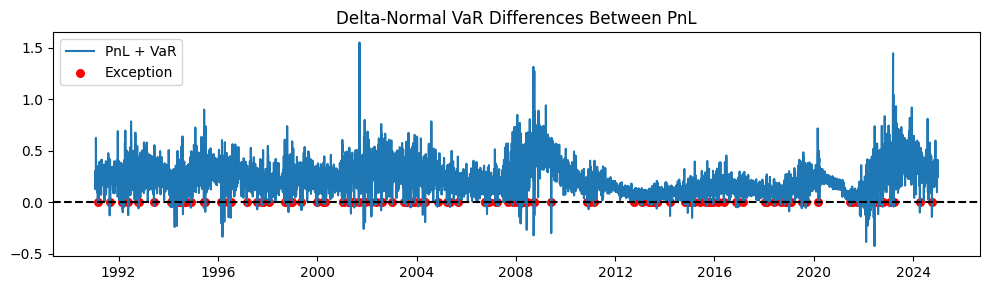

{'pi': 0.010211614173228346, 'p_value': 0.2810668103935574} ; Average Cost: 0.27900371158179194


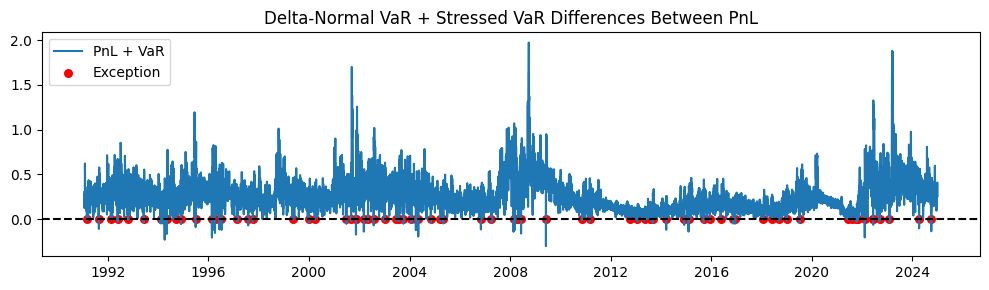

In [90]:
par_tenors = [0.5, 1, 2, 5, 7, 10]
zero_tenors = np.arange(1,11)
window = 252
maturity = 2
freq = 2
coupon_rate = 0.04
start = '1990-01-01'
end = '2025-01-01'
VaR, cVaR, pcas, explained_ratios, SVaRs = VaR_backtest(dgs.loc[start: end], window, maturity, freq, coupon_rate, par_tenors, notional = 100, shock = 0.0001, alpha = 0.99)

In [88]:
0.27900371158179194/0.2293246399704872 - 1

0.21663207066496715